## Textual Entailment Generation system training

In [1]:
import time, torch
import pandas as pd
import torch.nn as nn
import warnings, random
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline

from model import Seq2Seq
from training import *
from utils_model import EntailmentDataset, Vocabulary, word_tokenizer
from display_results import predict, display_attention


config = {"BATCH_SIZE" : 32,
          "HID_DIM" : 512,
          "N_LAYERS" : 2,
          "DROPOUT" : 0.3}

##### Load datasets and Build the vocabulary.
\* (specify the folder where the training partition of SNLI dataset is saved)

In [2]:
train_data = EntailmentDataset.load_dataset("\SNLI_PARTITION_FOLDER", split="train")
dev_data = EntailmentDataset.load_dataset("\SNLI_PARTITION_FOLDER", split="dev")
test_data = EntailmentDataset.load_dataset("\SNLI_PARTITION_FOLDER", split = "test")

voc = Vocabulary.build_vocabulary(train_data)

##### Load the pretrained Word2Vec model

In [3]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

w2v_embeddings, oov = create_w2v_matrix(voc.vocabulary, wv)

Number of words not found in pretrained w2v model: 2619


##### Initiate the Seq2Seq model and choose the loss and the optimizer to use

In [4]:
SEED = 1234
set_all_seeds(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You are using {device} device.")

model = Seq2Seq(pretrained_w2v = w2v_embeddings,
                hidden_size = config["HID_DIM"],
                n_layers = config["N_LAYERS"],
                dropout = config["DROPOUT"],
                device = device,
                additive_attention = True)

model = model.to(device)
model.apply(init_weights)
print(f'The seq2seq model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss(ignore_index = 0)

You are using cuda device.
The seq2seq model has 24,842,568 trainable parameters


#### Train the model

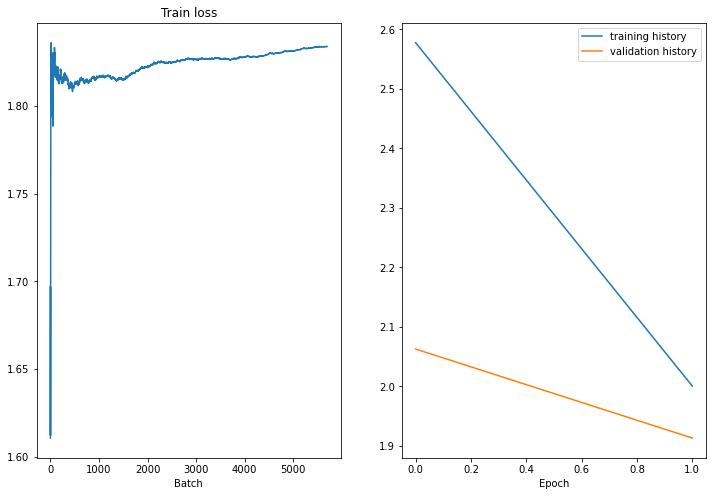


Epoch: 01 | Time: 21m 2s
	Train Loss: 1.834 
	 Val. Loss: 1.873 


In [10]:
torch.cuda.empty_cache()
train_history = []
valid_history = []

N_EPOCHS = 3

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss = train(model, voc, train_data, optimizer, criterion, device, train_history, valid_history)
    valid_loss = evaluate(model, voc, dev_data, criterion, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} ')
    print(f'\t Val. Loss: {valid_loss:.3f} ')

Sample n. 1165


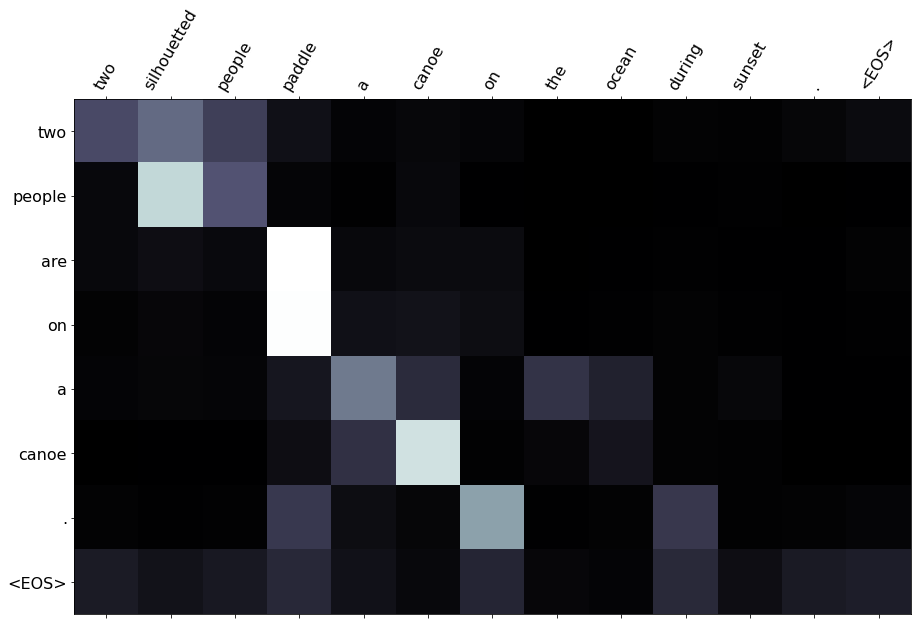

Sample n. 2099


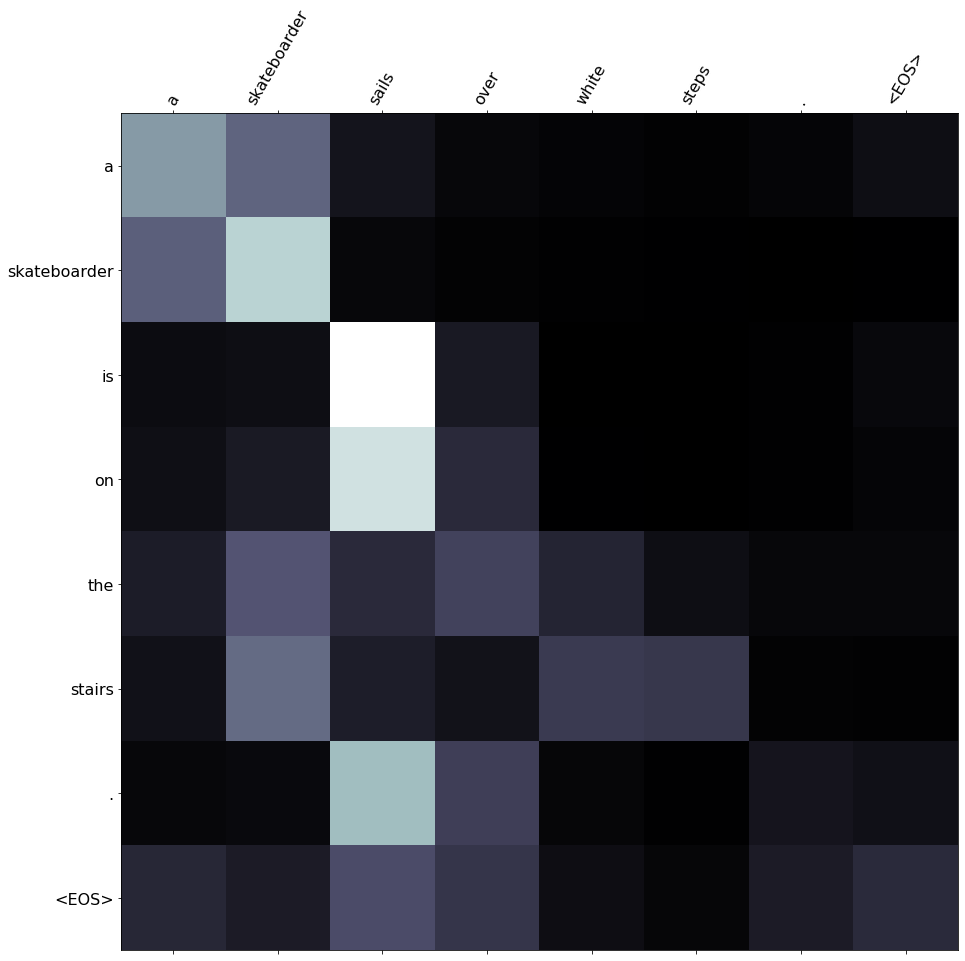

Sample n. 2074


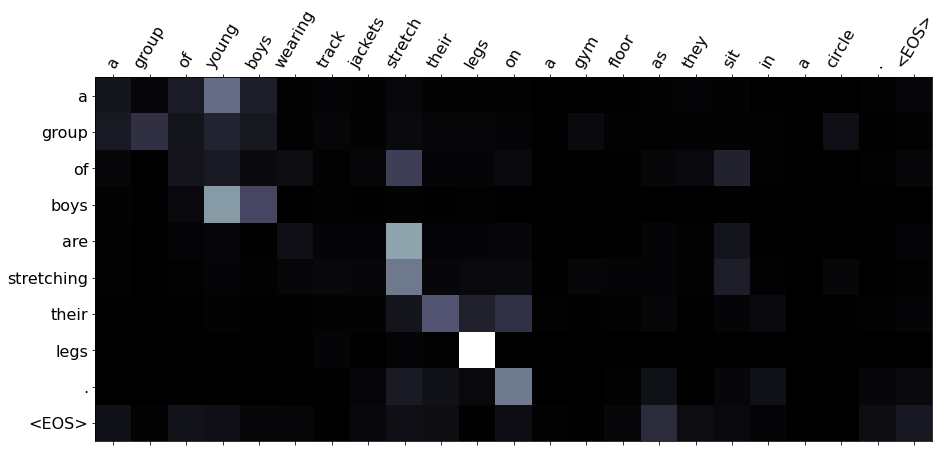

In [13]:
for index in random.choices(range(len(test_data)), k=3):
    print("Sample n.", index)
    premise, hypothesis = test_data[index]

    # generate the hypothesis
    pred_hypothesis, att_weights = predict(premise, model, voc, device)
    display_attention(premise, pred_hypothesis, att_weights)